In [3]:
import pandas
import numpy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

In [4]:
train = pandas.read_csv('CAB420_Assessment_1A_Data\Data\Q2\\testing.csv')
test = pandas.read_csv('CAB420_Assessment_1A_Data\Data\Q2\\training.csv')
train.head()

,class,b1,b2,b3,b4,b5,b6,b7,b8,b9,...,pred_minus_obs_H_b9,pred_minus_obs_S_b1,pred_minus_obs_S_b2,pred_minus_obs_S_b3,pred_minus_obs_S_b4,pred_minus_obs_S_b5,pred_minus_obs_S_b6,pred_minus_obs_S_b7,pred_minus_obs_S_b8,pred_minus_obs_S_b9
0,d,67,51,68,115,69,111,136,31,67,...,-9.17,-18.27,-1.80,-6.32,-20.88,-1.63,-6.13,-22.56,-5.53,-8.11
1,s,67,28,51,99,50,97,82,26,59,...,-2.25,-20.13,-2.11,-6.35,-21.94,-1.22,-6.13,-22.20,-3.41,-6.57
2,s,63,26,50,95,49,91,81,26,57,...,-0.44,-17.64,-1.81,-4.70,-19.39,-0.65,-5.01,-20.89,-3.96,-6.85
3,d,63,42,63,97,66,108,111,28,59,...,-2.34,-20.20,-1.89,-5.47,-21.65,-0.99,-5.71,-22.19,-3.41,-6.52
4,s,46,27,50,83,51,90,76,26,56,...,1.25,-18.62,-2.17,-7.11,-21.12,-1.56,-6.35,-22.19,-4.45,-7.32


In [5]:
test.head()

,class,b1,b2,b3,b4,b5,b6,b7,b8,b9,...,pred_minus_obs_H_b9,pred_minus_obs_S_b1,pred_minus_obs_S_b2,pred_minus_obs_S_b3,pred_minus_obs_S_b4,pred_minus_obs_S_b5,pred_minus_obs_S_b6,pred_minus_obs_S_b7,pred_minus_obs_S_b8,pred_minus_obs_S_b9
0,d,39,36,57,91,59,101,93,27,60,...,-2.36,-18.41,-1.88,-6.43,-21.03,-1.60,-6.18,-22.50,-5.20,-7.86
1,h,84,30,57,112,51,98,92,26,62,...,-2.26,-16.27,-1.95,-6.25,-18.79,-1.99,-6.18,-23.41,-8.87,-10.83
2,s,53,25,49,99,51,93,84,26,58,...,-1.46,-15.92,-1.79,-4.64,-17.73,-0.48,-4.69,-19.97,-4.10,-7.07
3,s,59,26,49,103,47,92,82,25,56,...,2.68,-13.77,-2.53,-6.34,-22.03,-2.34,-6.60,-27.10,-7.99,-10.81
4,d,57,49,66,103,64,106,114,28,59,...,-2.94,-21.74,-1.64,-4.62,-23.74,-0.85,-5.50,-22.83,-2.74,-5.84


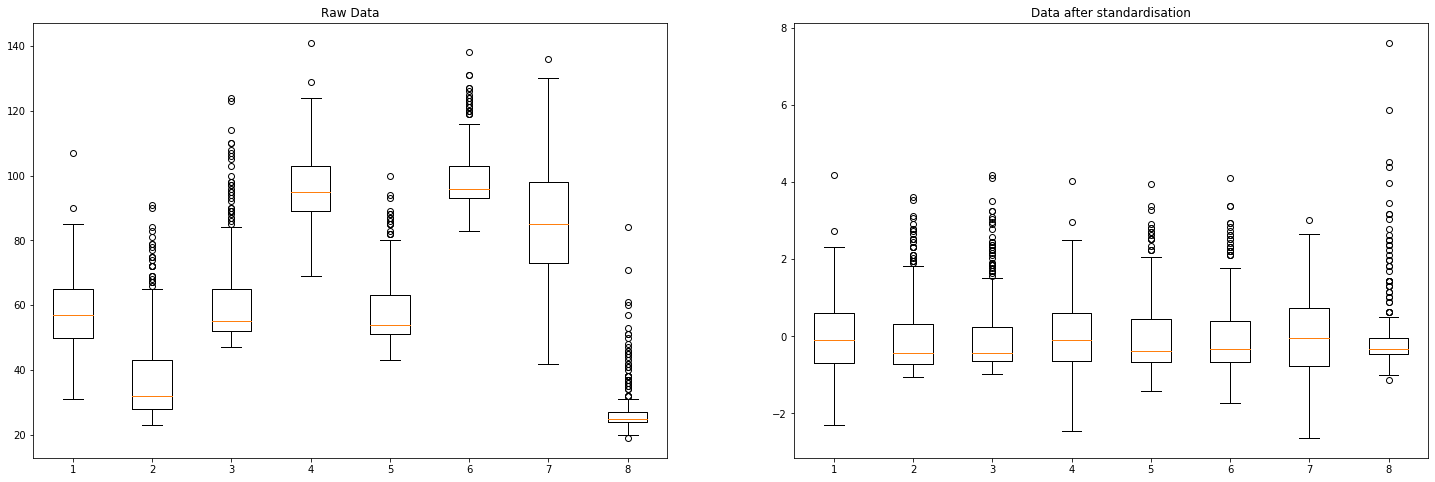

In [8]:
# get the data, we'll just grab 2 dimensions
X = train.iloc[:, 1:9].to_numpy()
train.iloc[:, 0] = train.iloc[:, 0].astype("category")
Y = train.iloc[:, 0].cat.codes.to_numpy()

# plot box plot for the data
fig = plt.figure(figsize=[25, 8])
ax = fig.add_subplot(1, 2, 1)
ax.boxplot(X)
ax.set_title('Raw Data')

# standardise data
mu = numpy.mean(X, 0)
sigma = numpy.std(X, 0)
X = (X - mu) / sigma

# box plot after standardisation
ax = fig.add_subplot(1, 2, 2)
ax.boxplot(X)
ax.set_title('Data after standardisation');